# Streamgage 11189500 Watershed

In [1]:

import os
import pickle
import sys
import time

import pandas as pd
import rasterio

sys.path.append(os.path.join("..", "..", "code"))
from google_helper_functions import (
    authenticate_gee, connect_to_service_account_gdrive, download_files_from_gdrive
)
from identify_watersheds import map_elevation_point, save_gee_elv_to_drive, WatershedIdentifier


DATA_DIR = os.path.join("..", "..", "data")
gages = pd.read_csv(os.path.join(DATA_DIR, "target_gages.csv"), encoding="utf-8")

In [2]:
# Target gage for this notebook:
ix = 1

gage = gages.iloc[ix]
lat, lon = gage["dec_lat_va"], gage["dec_long_va"]
name = gage["site_no"]
print(f"Streamgage: {name}")

Streamgage: 11189500


In [3]:
# Authenticate with service account:
service_acct = "capstone-gee-account@snow-capstone.iam.gserviceaccount.com"
keys = os.path.join(os.path.expanduser("~"), "snow-capstone-4a3c9603fcf0.json")
credentials = authenticate_gee(service_acct, keys)

# Alternative manual authentication method:
# ee.Authenticate()
# ee.Initialize()

In [4]:
# Plot the gage on an elevation map:
my_map = map_elevation_point(lat=lat, lon=lon, name=name, buffer=10_000, zoom_start=9)
my_map

In [5]:
# Export the geotiff to GDrive for the elevation image in the highlighted polygon:
task, filename = save_gee_elv_to_drive(lat, lon, name=name, buffer=10_000, scale=30)
while task.status()["state"] != "COMPLETED":
    time.sleep(1)
print("Complete")

Complete


In [6]:
# Download the file from G:Drive to a local copy:
drive = connect_to_service_account_gdrive(keys)
save_to = os.path.join(DATA_DIR, "gage_tiff_files")
local_files = download_files_from_gdrive(drive, filename, save_to, download_all=True)
tif_fp = local_files[0]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.01it/s]


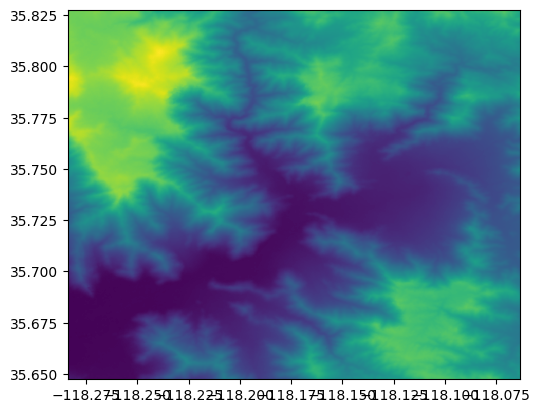

<AxesSubplot:>

In [7]:
# Inspect the raw TIF file:
from rasterio.plot import show

tif_data = rasterio.open(tif_fp)
show(tif_data, with_bounds=True)

In [8]:
ws = WatershedIdentifier(tif_fp, lat, lon, 1000)

/Users/tp/virtualenvs/discharge-estimation/lib/python3.9/site-packages/pysheds/io.py:142: UserWarning: No `nodata` value detected. Defaulting to 0.
  warnings.warn('No `nodata` value detected. Defaulting to 0.')
/Users/tp/virtualenvs/discharge-estimation/lib/python3.9/site-packages/pysheds/io.py:142: UserWarning: No `nodata` value detected. Defaulting to 0.
  warnings.warn('No `nodata` value detected. Defaulting to 0.')
/Users/tp/virtualenvs/discharge-estimation/lib/python3.9/site-packages/pysheds/io.py:142: UserWarning: No `nodata` value detected. Defaulting to 0.
  warnings.warn('No `nodata` value detected. Defaulting to 0.')


In [9]:
ws.summarize_catchment(30)

{'max_width_km': 17.55,
 'max_height_km': 10.98,
 'total_sq_m': 120103200.0,
 'total_sq_km': 120.1032}

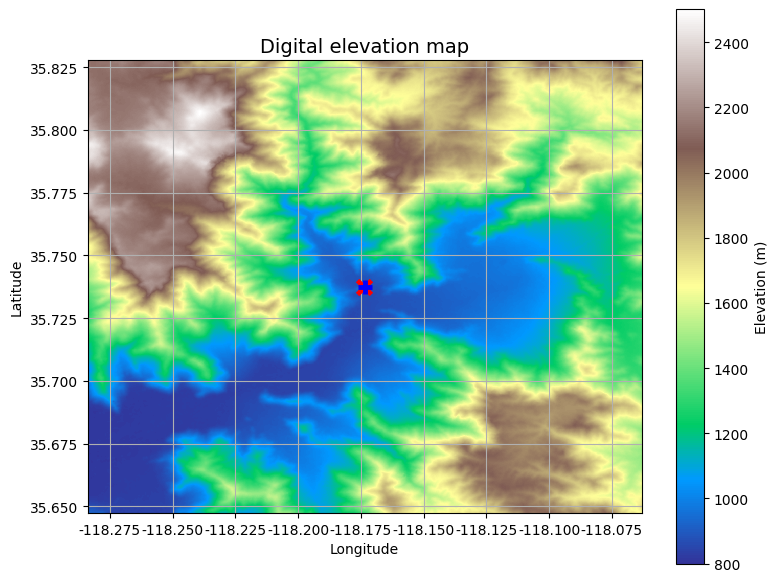

In [10]:
dem_fig = ws.plot_dem()

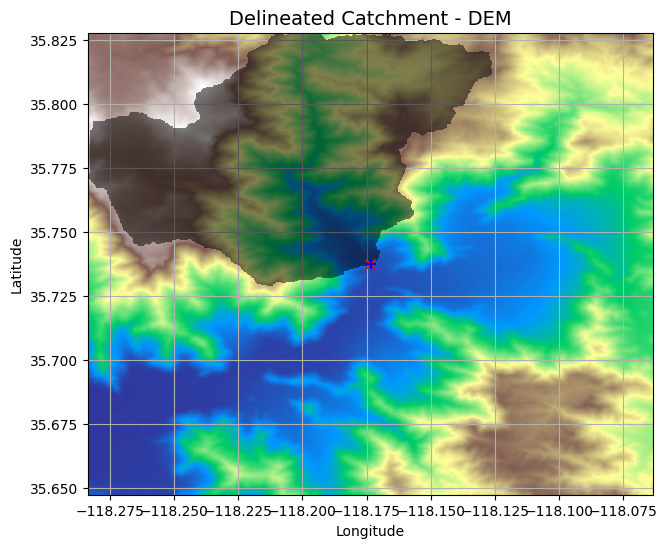

In [11]:
dem_c_map = ws.plot_catchment(base_map="dem")

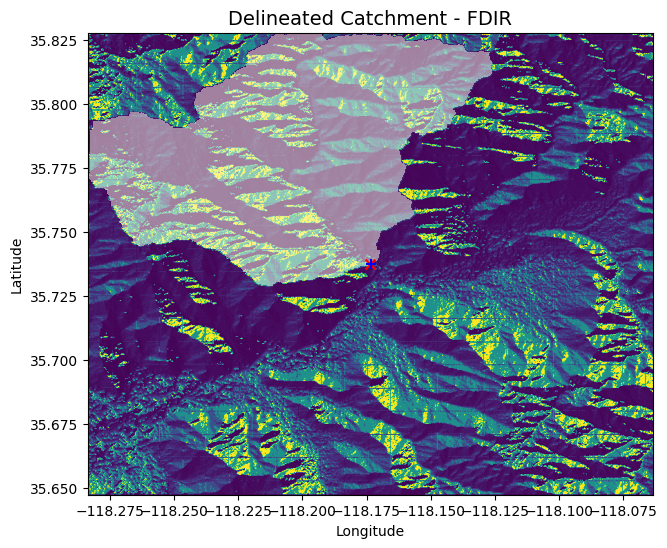

In [12]:
fdir_map = ws.plot_catchment(base_map="fdir")

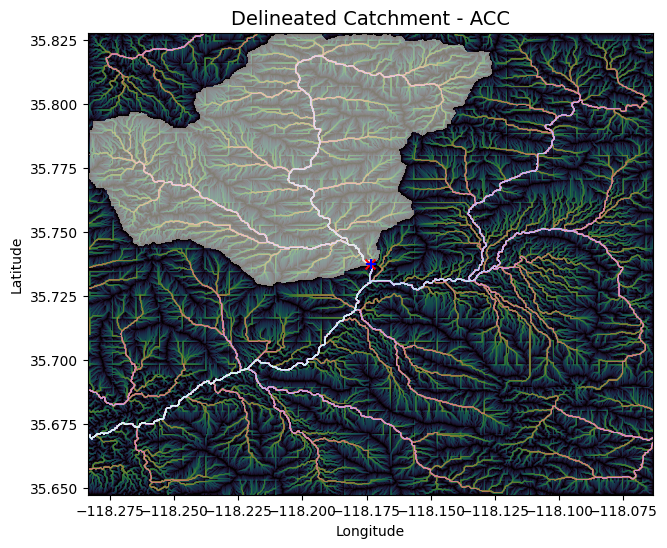

In [13]:
acc_map = ws.plot_catchment(base_map="acc")

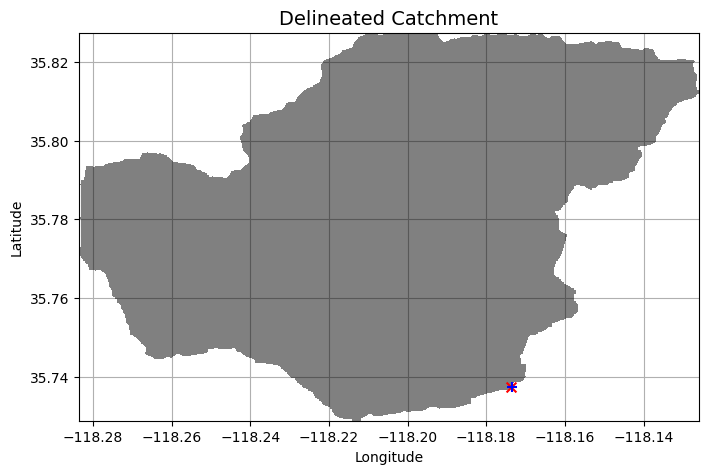

In [14]:
cm = ws.plot_catchment(base_map=None, clipped=True)

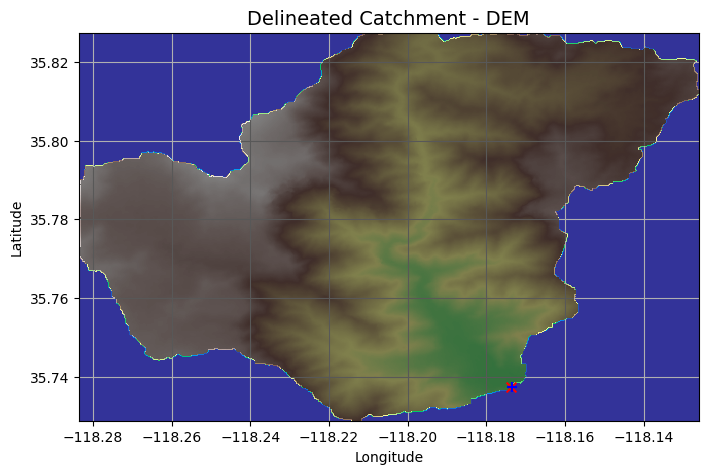

In [15]:
clipped_dem_map = ws.plot_catchment(base_map="dem", clipped=True)

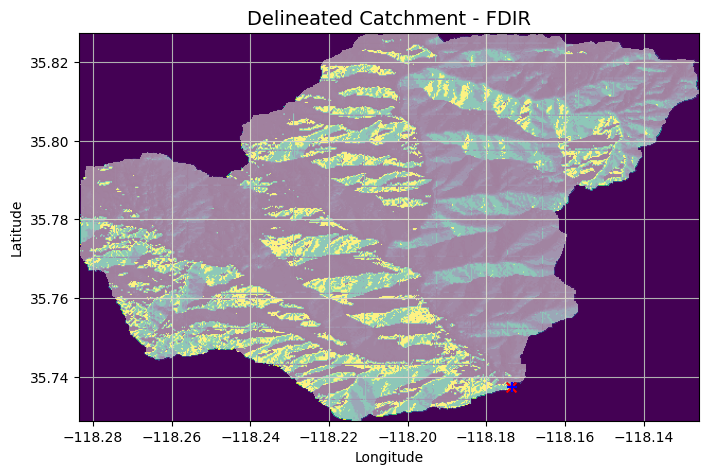

In [16]:
clipped_fdir_map = ws.plot_catchment(base_map="fdir", clipped=True)

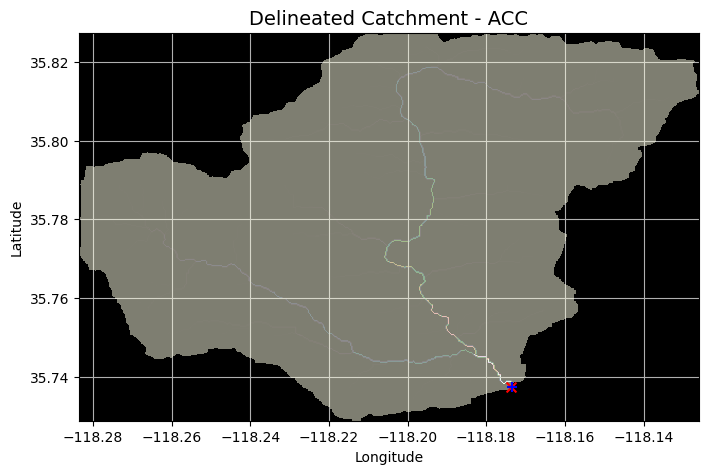

In [17]:
clipped_acc_map = ws.plot_catchment(base_map="acc", clipped=True)

In [18]:
# Save the watershed and confirm it can be reloaded:
pickled_fp = ws.save(os.path.join(DATA_DIR, "watersheds"), f"{name}")


def pickle_load(fp: str):
    with open(fp, "rb") as f:
        return pickle.load(f)
    

unpickled_ws = pickle_load(pickled_fp)
unpickled_ws.summarize_catchment()

{'max_width_km': 17.55,
 'max_height_km': 10.98,
 'total_sq_m': 120103200.0,
 'total_sq_km': 120.1032}